# 모듈 임포트

In [1]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import random
import torch.optim as optim
from torch.optim import AdamW
from torch import nn
from torch.utils.data import DataLoader, Dataset,TensorDataset
from torch.nn import functional as F
import re
import urllib.request
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(random_seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. 데이터 다운로드
깃허브에 존재하는 금융 뉴스 문장 감성 분석 데이터셋을 불러와 실험을 해보도록 하겠습니다.

In [2]:
url = "https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv"
file_name = os.getenv('HOME')+'/aiffel/mini_aiffelton/data/finance_data.csv'

urllib.request.urlretrieve(url,file_name) #파일을 다운로드하여 file_name으로 저장하는 함수

('/aiffel/aiffel/mini_aiffelton/data/finance_data.csv',
 <http.client.HTTPMessage at 0x7ff9d0241340>)

## 1-1. 데이터 로드

In [3]:
df=pd.read_csv(file_name)
df.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


# 2. 데이터 EDA

## 2-1. 데이터 null값 확인

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   object
 1   sentence      4846 non-null   object
 2   kor_sentence  4846 non-null   object
dtypes: object(3)
memory usage: 113.7+ KB


데이터는 총 4846개로 결측치는 없으며 labels, sentence, kor_sentence 3개의 열로 구성되어 있습니다.

## 2-2. 타겟 데이터 불균형 확인

In [5]:
df['labels'].value_counts()

neutral     2879
positive    1363
negative     604
Name: labels, dtype: int64

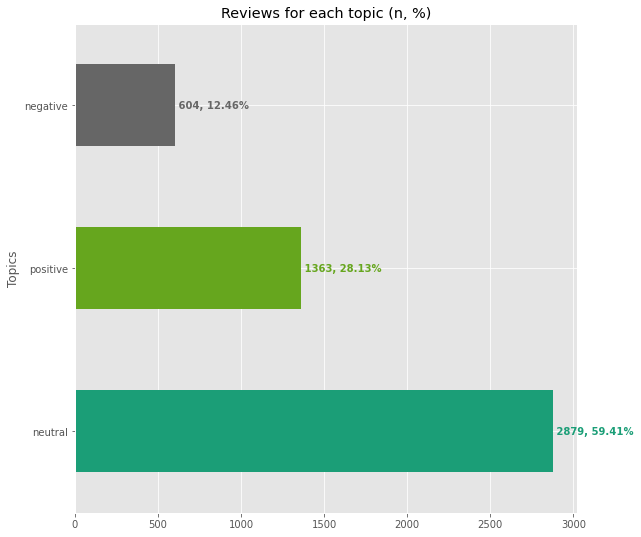

In [6]:
num_classes = len(df["labels"].value_counts()) #데이터프레임의 "labels" 열에 있는 고유한 레이블의 개수를 계산하여 변수 num_classes에 저장

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes)) #matplotlib의 cm 모듈을 사용하여 num_classes 개수에 맞게 컬러 맵을 생성
iter_color = iter(colors) #colors 배열에 대한 이터레이터를 생성 / 나중에 반복문에서 각 주제별로 다른 색상을 할당하기 위해 사용

df['labels'].value_counts().plot.barh(title="Reviews for each topic (n, %)",  # "labels" 열의 값들을 세어 막대 그래프로 그림
                                                 ylabel="Topics", #plot.barh함수를 사용하여 수평 막대 그래프를 생성
                                                 color=colors, #그래프의 제목, 축 레이블, 색상, 크기 등의 설정이 이곳에서 이루어짐
                                                 figsize=(9,9))

for i, v in enumerate(df['labels'].value_counts()): #주제별 리뷰 수를 순회
  c = next(iter_color) #이터레이터 iter_color에서 다음 색상을 가져와 변수 c에 할당
  plt.text(v, i, #막대 그래프에 주제별 리뷰 수와 해당 비율을 텍스트로 표시
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%",  #v는 리뷰 수, i는 인덱스를 나타냄
           color=c, 
           va='center', 
           fontweight='bold')

타겟 레이블을 살펴보았을때, negative 데이터셋이 적은 불균형한 데이터셋임을 확인할 수 있습니다.

## 2-3. 문장 중복 처리

In [7]:
df.drop_duplicates(inplace=True)
print('중복을 제거한 데이터 수:',len(df))

중복을 제거한 데이터 수: 4840


중복 데이터 6개를 제거하고 총 4840개의 데이터를 사용하도록 하겠습니다.

## 2-4. 데이터 길이 확인

문장의 최소 길이 :5
문장의 최대 길이 :195
문장의 평균 길이 :60.78181818181818


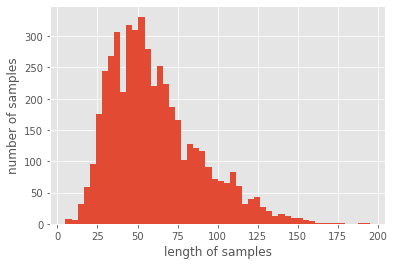

In [8]:
print('문장의 최소 길이 :{}'.format(min(len(l) for l in df['kor_sentence'])))
print('문장의 최대 길이 :{}'.format(max(len(l) for l in df['kor_sentence'])))
print('문장의 평균 길이 :{}'.format(sum(map(len, df['kor_sentence']))/len(df['kor_sentence'])))

plt.hist([len(s) for s in df['kor_sentence']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

문장의 최소 길이는 5에서 문장의 최대 길이는 195로 평균 길이는 60임

In [9]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [10]:
max_len = 128
below_threshold_len(max_len, df['kor_sentence'])

전체 샘플 중 길이가 128 이하인 샘플의 비율: 97.56198347107437


# 3. 데이터 전처리

## 3-1. 필요없는 컬럼 삭제

In [11]:
df1 = df[['labels', 'kor_sentence']]
df1.head()

,labels,kor_sentence
0,neutral,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


## 3-2. replace 함수를 통한 레이블 변환

In [12]:
df1['labels'] = df1['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
df.head()

/tmp/ipykernel_70/2900377179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['labels'] = df1['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])


,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


## 3-3. 클래스 및 함수 만들기

In [13]:
def transform(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'\([^)]*\)', r'', sentence) #괄호로 둘러싸인 부분 제거
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence) #문장 내의 구두점을 공백과 함께 분리
    sentence = re.sub(r'[^a-zA-Z가-힣0-9?.!, ]+', r' ', sentence) #영문 알파벳, 한글, 숫자, 구두점을 제외한 모든 문자를 제거
    sentence = re.sub(r"['\n']+", r"", sentence) #개행 문자 제거
    sentence = re.sub(r'["   "]+', " ", sentence) #연속된 공백을 하나의 공백으로 변환
    
    return sentence

In [14]:
class TrainTestDataset(Dataset):
    def __init__(self, dataframe, transform=True, train=True):
        self.data = dataframe
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.train: #train data이면 sentence와 label 같이 전처리
            labels = self.data['labels'][index]
            sentence = self.data['kor_sentence'][index]
        else: #test data이면 label만 같이 전처리
            sentence = self.data['kor_sentence'][index]

        if self.transform: #앞서 정의한 transform 함수로 sentence 전처리
            sentence = transform(sentence)

        encoded_dict = tokenizer.encode_plus( # Hugging Face의 토크나이저를 초기화한 후 사용
            sentence, #인코딩할 대상 문장
            add_special_tokens=True, #특수 토큰(Special Token)을 문장에 추가할지 여부를 지정
            max_length=MAX_LEN, #문장의 최대 길이를 지정 / 길이가 MAX_LEN보다 긴 문장은 자름
            padding='max_length', #문장을 패딩하여 동일한 길이로 맞춰줌 / 패딩은 문장의 뒷부분에 [PAD] 토큰을 추가
            truncation=True, #문장이 최대 길이를 초과할 경우 자르기(truncation)를 수행
            return_tensors='pt' #결과를 PyTorch의 텐서로 반환
        )

        padded_token_list = encoded_dict['input_ids'][0]
        token_type_id = encoded_dict['token_type_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]

        if self.train: #train일 경우 padded_token_list, token_type_id, att_mask, target을 반환
            target = torch.tensor(labels)
            sample = (padded_token_list, token_type_id, att_mask, target)
        else: #test일 경우 padded_token_list, token_type_id, att_mask을 반환
            sample = (padded_token_list, token_type_id, att_mask)

        return sample

## 3-4. 사전학습 모델 불러오기

In [15]:
model_name = "monologg/kobigbird-bert-base" #허깅페이스에서 모델만 갈아끼우면 됨

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 3) #예측하고자 하는 클래스의 수를 넣어줘야함
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassific

# 4. 데이터 만들기 

In [16]:
# 데이터프레임의 인덱스를 리스트로 저장
indices = df1.index.tolist()

np.random.seed(random_seed)
# 인덱스를 랜덤하게 섞음
np.random.shuffle(indices)

# 8:2로 인덱스를 나눔
split = int(0.8 * len(indices))
train_indices = indices[:split]
test_indices = indices[split:]

# 훈련 데이터와 테스트 데이터로 나눔
train_data = df1.loc[train_indices].reset_index(drop=True)
test_data = df1.loc[test_indices].reset_index(drop=True)

print('train data 길이:',len(train_data))
print('test data 길이:',len(test_data))

train_data.head()

train data 길이: 3872
test data 길이: 968


,labels,kor_sentence
0,0,"공정 및 자원, 산업기계, 건축, 건축, 건설, 전기, 운송, 전자, 화학, 석유화..."
1,0,관계자들은 계약 금액을 공개하지 않았다.
2,0,추출된 여과물은 투명도가 매우 높은 반면 건조 필터 케이크는 광석 등급에 필요한 운...
3,0,"이 도구는 특허 출원 중인 디자인으로, 소비자가 여러 종류의 클리어 스탬프를 사용하..."
4,0,"핀란드에서는 알마미디어의 Etuovi.com이 해당 서비스를 제공하고 있는데, 이는..."


In [17]:
MAX_LEN = 128
epochs = 10
BATCH_SIZE = 8
NUM_CORES = 0

# -> 32로 되는것 확인했음

In [18]:
train_dataset = TrainTestDataset(train_data, transform=True, train = True)
test_dataset = TrainTestDataset(test_data, transform=True, train = False)

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                      num_workers=NUM_CORES)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                      num_workers=NUM_CORES)

In [20]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(32500, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0): BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [21]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps = 1e-8)

# 5. 훈련

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [23]:
# train
#FocalLoss 모델 이름 저장 다시 한번 확인해야함 -> 기존에 있던 모델에 덮어씌워질 수 있음(주의하기)
output = os.getenv('HOME')+'/aiffel/mini_aiffelton/model/'
model_name1 = model_name.replace('/','_')

losses = []
accuracies = []

model.train()

for i in range(epochs):

    total_loss = 0.0
    correct = 0
    total = 0

    for input_ids_batch, token_type_id_batch, attention_masks_batch, y_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        y_batch = y_batch.to(device)
        input_ids_batch = input_ids_batch.to(device)
        token_type_id_batch = token_type_id_batch.to(device)
        attention_masks_batch = attention_masks_batch.to(device)
        y_pred = model(input_ids_batch, token_type_ids = token_type_id_batch, attention_mask=attention_masks_batch)[0].to(device)
        loss = FocalLoss()(y_pred, y_batch) #focalloss 사용시
#         loss = F.cross_entropy(y_pred, y_batch) #일반loss 사용시
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y_batch).sum()
        total += len(y_batch)
  
    losses.append(total_loss)
    accuracies.append(correct.float() / total)
    torch.save(model.state_dict(), os.path.join(output,f'{model_name1}_classification_model_{i+1}.pt'))
    print("Train Loss:", total_loss / total, "Accuracy:", correct.float() / total)

100%|██████████| 484/484 [01:56<00:00,  4.16it/s]


Train Loss: 0.006907432273940437 Accuracy: tensor(0.7678, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.003791489756607435 Accuracy: tensor(0.8577, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.0025851285601133857 Accuracy: tensor(0.8977, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.0019119228683908765 Accuracy: tensor(0.9238, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.0013510545027089422 Accuracy: tensor(0.9465, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.0009379918135399455 Accuracy: tensor(0.9641, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.0007726130648651716 Accuracy: tensor(0.9762, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.0006396497902296537 Accuracy: tensor(0.9783, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.0003873776425201161 Accuracy: tensor(0.9848, device='cuda:0')


100%|██████████| 484/484 [01:55<00:00,  4.20it/s]


Train Loss: 0.0004345493548790044 Accuracy: tensor(0.9819, device='cuda:0')


# 6. 평가

100%|██████████| 121/121 [00:09<00:00, 12.50it/s]


0.8491735537190083
              precision    recall  f1-score   support

     neutral       0.89      0.88      0.88       599
    positive       0.77      0.77      0.77       252
    negative       0.84      0.85      0.84       117

    accuracy                           0.85       968
   macro avg       0.83      0.83      0.83       968
weighted avg       0.85      0.85      0.85       968



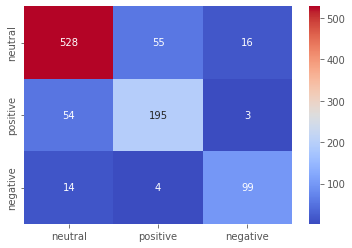

In [24]:
model.eval()

pred = []

with torch.no_grad():
    for input_ids_batch, token_type_id_batch, attention_masks_batch in tqdm(test_dataloader):
        y_pred = model(input_ids_batch.to(device),token_type_ids = token_type_id_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
        _, predicted = torch.max(y_pred, 1)
        pred.extend(predicted.tolist())
        
print(accuracy_score(pred, test_data['labels']))
print(classification_report(test_data['labels'], pred, target_names=['neutral', 'positive', 'negative']))
cm = confusion_matrix(test_data['labels'], pred)
sns.heatmap(cm, annot = True, cmap='coolwarm', xticklabels=['neutral', 'positive', 'negative'], yticklabels=['neutral', 'positive', 'negative'], fmt='d')
plt.show()